# Overview
## Imbal2 part
*Slightly vestigial background*: 
Our study-test version so far has an "imbalaced" order (20 targets, 44 lures, 20 foils) and an even-ish representation of bins 1-5.  Here, we want to skew that distribution of lure bins.  We're going to have it do 5,6,11,11,11

Our continuous version has been focused on 3 bins (e.g., 2-4) and we're going to cover the range but skew it as well

## Imbal 2x3 part
*What's new here*
Each image set has 192 full pairs with roughly equal representation across the 5 lure bins. Each imbal2 order here is using 64 images. If we play our cards right, we should be able to do 3 sublists per list (the x3 bit). *This only works for continuous though*. For study-test, we need separate foils and could do 2 sublists, but we can eek out 3 if we don't have unrelated foils and if all our foils come from first presentations (as in the published oMST)

So, for each run through here, we make 3 sublists and we only make the continuous version of the order file

## Flat x2 part
Imbal2x3 is all fine and good for older adults.  We save a bit of time by having only 5 lure-1 and 6 lure-2 (11 of the others). This also lets us have 3 subsets per set here.  All good stuff.  But, if we want something that will be more sensitive in younger adults, we may want more trials in bins 1 and 2 there.  So, we have the "flat" version.  I've created order files with 150 trials (55 lure pairs) to use for this.  But, we've now used up enough trials that we can only have 2 subsets per set.  So `Flatx2`.

## Terminology
The MATLAB code `CreateOrder_Imbal.m` makes a file that we can call an *orderpattern* file. It has an arcane code (that should be fixed) that lets other bits of code know "hey, the first trial is a 1st presentation as is the 2nd...  The 10th is a repeat, etc" along with which ordinal stimulus number to use.  Note the odd "ordinal stimulus number" bit.  That isn't an image number like 001a.jpg, but rather an abstract "the first lure stimulus, whatever that might be" kind of thing.  Hence, this file gives the pattern of trials, but isn't actually about stimuli themselves.

Here, we make .js files that actually spell out an order of trials to present (along with the metadata for those trials)

In [10]:

import os, csv
import numpy as np
import glob

nrepeats=20
nlures=44
nfoils=0  # Foils here come from 1st presentations -- this code is only setup for continuous

NImagePairs = 192

print(os.getcwd())
basepath=os.getcwd()
os.chdir(basepath)
rng=np.random.default_rng()

def check_files(SetName,validate_images=False,base_dir='../'):
    """ 
    SetName should be something like "C" or "1"
    Checks to make sure there are the right #of images in the image directory
    Loads the lure bin ratings into the global set_bins list and returns this
    base_dir: typically the main exp. folder.  Holds the bin files
    """

    #print(SetName)
    #print(P_N_STIM_PER_LIST)
    
    bins = []  # Clear out any existing items in the bin list

    # Load the bin file
    with open(base_dir+"Set"+str(SetName)+" bins.txt","r") as bin_file:
        reader=csv.reader(bin_file,delimiter='\t')
        for row in reader:
            if int(row[0]) > NImagePairs:
                raise ValueError('Stimulus number ({0}) too large - not in 1-192 in binfile'.format(row[0]))
            if int(row[0]) < 1:
                raise ValueError('Stimulus number ({0}) too small - not in 1-192 in binfile'.format(row[0]))
            bins.append(int(row[1]))
    if len(bins) != NImagePairs:
        raise ValueError('Did not read correct number of bins in binfile')
    
    # Check the stimulus directory
    if validate_images:
        img_list=glob.glob("Set" +str(SetName) + '_rs' + os.sep + '*.jpg')
        if len(img_list) < (2*NImagePairs):
            raise ValueError('Not enough files in stimulus directory {0} -- {1} vs {2}'.format("Set " +str(SetName) + os.sep + '*.jpg',len(img_list),2*NImagePairs))
        for i in range(1,NImagePairs+1):
            if not os.path.isfile("Set" +str(SetName) + '_rs' + os.sep + '{0:03}'.format(i) + 'a.jpg'):
                raise ValueError('Cannot find: ' + "Set " +str(SetName) + os.sep + '{0:03}'.format(i) + 'a.jpg')
            if not os.path.isfile("Set" +str(SetName) + '_rs' + os.sep + '{0:03}'.format(i) + 'b.jpg'):
                raise ValueError('Cannot find: ' + "Set " +str(SetName) + os.sep + '{0:03}'.format(i) + 'b.jpg')
    return bins


def setup_list_permutedx3(set_bins,verbose=False):
    """
    set_bins = list of bin values for each of the 192 stimuli -- set specific
    
    Assumes check_files() has been run so we have the bin numbers for each stimulus

    Assumes the nrepeats and nlures set globally
      
    Returns arrays (nstim x 3) with the image numbers for each stimulus type (repeat and lures)
    in the to-be-used permuted order with the to-be-used list size

    8/2/23: Re-written to do 3 sublists keeping the lure bin balance across sublists and to not do any foils as it's continuous only

    """

    
    if len(set_bins) != NImagePairs:
        raise ValueError('Set bin length is not the same as the stimulus set length ({0})'.format(NImagePairs))

    if (nrepeats > 64) or (nlures > 64) or (nfoils > 64):
        raise ValueError('Not setup to have any stim type >64 at the moment')
        
    # Figure the image numbers for the lure bins
    lure1=np.where(set_bins == 1)[0] + 1
    lure2=np.where(set_bins == 2)[0] + 1
    lure3=np.where(set_bins == 3)[0] + 1
    lure4=np.where(set_bins == 4)[0] + 1
    lure5=np.where(set_bins == 5)[0] + 1
    if verbose:
        print('Lure bin counts: ',len(lure1),len(lure2),len(lure3),len(lure4),len(lure5))
    
    # Permute these
    lure1 = rng.permutation(lure1)
    lure2 = rng.permutation(lure2)
    lure3 = rng.permutation(lure3)
    lure4 = rng.permutation(lure4)
    lure5 = rng.permutation(lure5)

    lures=np.empty([nlures,3],dtype=int)
    #nonlures=np.empty(NImagePairs-nlures,dtype=int)

    # Build up my list of lures and nonlures
    bincount=np.array([5,6,11,11,11])
    binind=bincount.cumsum()
    lures[0:binind[0],0]=lure1[0:bincount[0]]  # 5 of these
    lures[0:binind[0],1]=lure1[bincount[0]:2*bincount[0]]
    lures[0:binind[0],2]=lure1[2*bincount[0]:3*bincount[0]]
    nonlures=lure1[3*bincount[0]:]
    if verbose:
        print(len(nonlures),'in non-lure count after bin 1')

    lures[binind[0]:binind[1],0]=lure2[0:bincount[1]]
    lures[binind[0]:binind[1],1]=lure2[bincount[1]:2*bincount[1]]
    lures[binind[0]:binind[1],2]=lure2[2*bincount[1]:3*bincount[1]]
    nonlures=np.hstack((nonlures,lure2[3*bincount[1]:]))
    if verbose:
        print(len(nonlures),'in non-lure count after bin 2')

    lures[binind[1]:binind[2],0]=lure3[0:bincount[2]]
    lures[binind[1]:binind[2],1]=lure3[bincount[2]:2*bincount[2]]
    lures[binind[1]:binind[2],2]=lure3[2*bincount[2]:3*bincount[2]]
    nonlures=np.hstack((nonlures,lure3[3*bincount[2]:]))
    if verbose:
        print(len(nonlures),'in non-lure count after bin 3')
    
    lures[binind[2]:binind[3],0]=lure4[0:bincount[3]]
    lures[binind[2]:binind[3],1]=lure4[bincount[3]:2*bincount[3]]
    lures[binind[2]:binind[3],2]=lure4[2*bincount[3]:3*bincount[3]]
    nonlures=np.hstack((nonlures,lure4[3*bincount[3]:]))
    if verbose:
        print(len(nonlures),'in non-lure count after bin 4')
    
    lures[binind[3]:binind[4],0]=lure5[0:bincount[4]]
    lures[binind[3]:binind[4],1]=lure5[bincount[4]:2*bincount[4]]
    lures[binind[3]:binind[4],2]=lure5[2*bincount[4]:3*bincount[4]]
    nonlures=np.hstack((nonlures,lure5[3*bincount[4]:]))
    if verbose:
        print(len(nonlures),'in non-lure count after bin 5')
    
    if verbose:
        print(' remaining non-lure count: ',len(nonlures))
    # Randomize the lures and non-lures and split into the lengths we need
    lurestim=rng.permutation(lures,axis=0)
    nonlures=rng.permutation(nonlures)
    #proto_foils=nonlures[0:3*nfoils]
    #proto_repeats=nonlures[3*nfoils:]
    proto_repeats=nonlures[0:3*nrepeats]
    #if verbose:
    #    print('   divvied into',len(proto_foils),'for foils and',len(proto_repeats),'for repeats')
    
    # foilstim = np.empty([nfoils,3],dtype=int)
    # foilstim[:,0]=proto_foils[0:nfoils]
    # foilstim[:,1]=proto_foils[nfoils:2*nfoils]
    # foilstim[:,2]=proto_foils[2*nfoils:3*nfoils]

    repeatstim = np.empty([nrepeats,3],dtype=int)
    repeatstim[:,0]=proto_repeats[0:nrepeats]
    repeatstim[:,1]=proto_repeats[nrepeats:2*nrepeats]
    repeatstim[:,2]=proto_repeats[2*nrepeats:3*nrepeats]          
    return (repeatstim,lurestim)
    

def load_and_decode_orderpattern(repeat_list,lure_list,stim_set, set_bins,
                          pattern_dir='misc',orderpattern='1',base_dir='..',
                          ):
    """
    Loads the order text file and decodes this into a list of image names, 
     conditions, lags, etc.
    
    base_dir: Directory that holds the main code, esp. the stimulus bin text files
    pattern_dir: Directory name with the orderpattern files relative to base_dir
    orderpattern: Which order file to use (numeric index) - expects "order_1.txt" or some such thing
    stim_set = Set we're using (e.g., '1', or 'C')
    repeat_list,lure_list,foil_list: Lists (np.arrays actually) created by setup_list_permuted
    
    Yes, you should want to shoot me after reading the next bit. No, I don't really know why I decided to
    pack all this info into one number rather than several. But, the deed is done and until we rewrite
    a bunch of code, we're stuck with this.

    In the order files files we have 2 columns:
        1st column is the stimulus type + number:
        Offset_1R = 0; % 1-100 1st of repeat pair
        Offset_2R = 100; % 101-200  2nd of repeat pair
        Offset_1L = 200; % 201-300 1st of lure pair
        Offset_2L = 300; % 301-400 2nd of lure pair
        Offset_Foil = 400; % 401+ Foil
        
        2nd column is the lag + 500 (-1 for 1st and foil)

    Returns:
        lists / arrays that are all N-trials long
        
        type_code: 0=1st of repeat
                   1=2nd of repeat
                   2=1st of lure
                   3=2nd of lure
                   4=foil
        ideal_resp: 0=old
                    1=similar
                    2=new
        lag: Lag for this item (-1=1st/foil, 0=adjacent, N=items between)
        fnames: Actual filename of image to be shown
    """
    fname=os.path.join(base_dir,pattern_dir, "order_{0}.txt".format(orderpattern))
    fdata=np.genfromtxt(fname,dtype=int,delimiter=',')
    
    lag = fdata[:,1]
    lag[lag != -1] = lag[lag != -1] - 500
    
    type_code = fdata[:,0]//100  #Note, this works b/c we loaded the data as ints
    
    stim_index = fdata[:,0]-100*type_code
    #print(stim_index)
    #set_bins = np.array(check_files(stim_set))
    #lbins=set_bins[stim_index-1]
    #print(set_bins,'len=',len(set_bins))
    #print(stim_index,'len=',len(stim_index))
    #print(lbins,'len=',len(lbins))
    lbins=np.zeros_like(stim_index)
    
    ideal_resp = np.zeros_like(stim_index)
    ideal_resp[type_code==4]=2
    ideal_resp[type_code==0]=2
    ideal_resp[type_code==2]=2
    ideal_resp[type_code==1]=0
    ideal_resp[type_code==3]=1
    
    fnames=[]
#    dirname='Set {0}{1}'.format(stim_set, os.sep)  # Get us to the directory
    dirname='Set {0}_rs/'.format(stim_set)  # Get us to the directory
    print(len(type_code),fname)
    for i in range(len(type_code)):
        stimfile='UNKNOWN'
        if type_code[i]==0 or type_code[i]==1:
            stimfile='{0:03}a.jpg'.format(repeat_list[stim_index[i]-1])
            lbins[i]=set_bins[repeat_list[stim_index[i]-1]-1]
        elif type_code[i]==2:
            stimfile='{0:03}a.jpg'.format(lure_list[stim_index[i]-1])
            lbins[i]=set_bins[lure_list[stim_index[i]-1]-1]
        elif type_code[i]==3:
            stimfile='{0:03}b.jpg'.format(lure_list[stim_index[i]-1])
            lbins[i]=set_bins[lure_list[stim_index[i]-1]-1]
        elif type_code[i]==4:  # Should not actually have these for the oMST
            print('UHHHH  WHY IS THERE A TYPE 4 TRIAL???')
            stimfile='{0:03}a.jpg'.format(foil_list[stim_index[i]-1])
            lbins[i]=set_bins[lure_list[stim_index[i]-1]-1]
        fnames.append(dirname+stimfile)
    
    return (type_code,ideal_resp,lag,fnames,lbins)

def CreateJSFilex3(stim_set='1',out_dir='../jsOrders',orderpattern=1,json=True):
    set_bins = np.array(check_files(stim_set))
    # Figure out which stimuli will be shown in which conditions and order them
    print('Ordering...')
    # These are nstim x 3 arrays that will allow us to make 3 runs per stimulus set
    repeat_list, lure_list = setup_list_permutedx3(set_bins)
    
       
    for run in range(3):  # We've hard-coded that we can have 3 runs here
        # Load up the order file and decode it, creating all the needed vectors
        type_code,ideal_resp,lag,fnames,lbins=load_and_decode_orderpattern(repeat_list[:,run],
                lure_list[:,run],stim_set, set_bins)
        outname=os.path.join(out_dir,f'cMST_Imbal2x3_orders_{stim_set}_{orderpattern}_{run+1}.js')
        print(outname)
        fp=open(outname,'w')
        fp.write('var trial_stim=[\n')
        if json:
            jsonoutname=outname+'on'
            fp2=open(jsonoutname,'w')
            fp2.write('[\n')        
        for i in np.arange(len(type_code)):
            #lbin=set_bins[stimnum-1] # images are 1-indexed
            fp.write('  {' + "trial: {0}, image: '{1}', type: {2}, correct_resp: {3}, lag: {4}, lbin: {5}".format(
                    i,fnames[i],type_code[i],ideal_resp[i],lag[i],lbins[i]) +'}')
            if json:
                fp2.write('  {' + '"trial": {}, "image": "{}", "type": {}, "correct_resp": {}, "lag": {}, "lbin": {}'.format(
                    i,fnames[i],type_code[i],ideal_resp[i],lag[i],lbins[i]) +'}')
            if i < (len(type_code)-1):
                fp.write(',\n')
                if json:
                    fp2.write(',\n')
            else:
                fp.write('\n')
                if json:
                    fp2.write('\n')
        fp.write(']\n')
        fp.close()
        if json:
            fp2.write(']\n')
            fp2.close()

def ImbalCreatex3(orderpattern=1):
    for sset in np.arange(1,7):
        CreateJSFilex3(stim_set=str(sset), orderpattern=orderpattern)




c:\Users\craig\dev\jatos_win_java\study_assets_root\oMST\misc


In [ ]:
# set_bins = np.array(check_files('1'))
# repeat_list, lure_list = setup_list_permutedx3(set_bins,verbose=True)
ImbalCreatex3()
#CreateOrderFile(stimset='1')
#CreateOrderFile(stimset='2')
#CreateOrderFile(stimset='3')
#CreateOrderFile(stimset='4')
#CreateOrderFile(stimset='5')
#CreateOrderFile(stimset='6')
#CreateOrderFile(stimset='1',prefix='MST_imbalX')


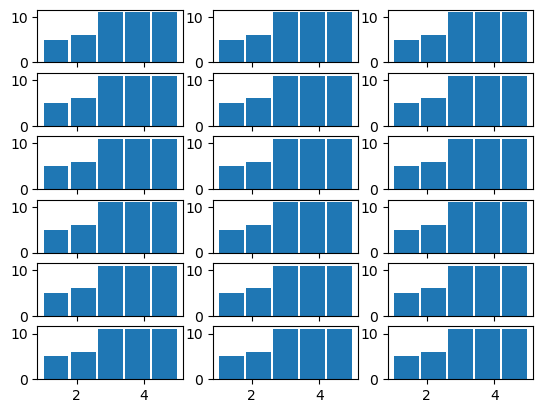

In [28]:
# Veryify the files have the right lure bin distributions
import json
from matplotlib import pyplot as plt

for run in range(3):
    for set in range(6):
        
        plt.subplot(6,3,run*6+set+1)
        fname=f'../jsOrders/cMST_Imbal2x3_orders_{set+1}_1_{run+1}.js'
        fp = open(fname,"r")
        rawdata=fp.readlines()
        i=0
        bindata=np.empty(44)
        for line in rawdata:
            if line.strip().startswith('{'):
                recode=line.strip().replace('trial','"trial"').replace('image','"image"').replace('type','"type"').replace('correct_resp','"correct_resp"').replace('lag','"lag"').replace('lbin','"lbin"').replace("'",'"').replace('},','}')
                #print(recode)
                jsd=json.loads(recode)
                if jsd['type']==3:
                    bindata[i]=jsd['lbin']
                    i=i+1

        plt.hist(bindata,bins=5,rwidth=0.9)

# Flat version
Imbal2x3 is all fine and good for older adults.  We save a bit of time by having only 5 lure-1 and 6 lure-2 (11 of the others). This also lets us have 3 subsets per set here.  All good stuff.  But, if we want something that will be more sensitive in younger adults, we may want more trials in bins 1 and 2 there.  So, we have the "flat" version.  I've created order files with 150 trials (55 lure pairs) to use for this.  But, we've now used up enough trials that we can only have 2 subsets per set.  So `Flatx2`.

Make sure to source the stuff at the top first...

In [14]:
nrepeats=20
nlures=55
nfoils=0  # Foils here come from 1st presentations -- this code is only setup for continuous

def setup_list_permutedx2(set_bins,verbose=False):
    """
    set_bins = list of bin values for each of the 192 stimuli -- set specific
    
    Assumes check_files() has been run so we have the bin numbers for each stimulus

    Assumes the nrepeats and nlures set globally
      
    Returns arrays (nstim x 2) with the image numbers for each stimulus type (repeat and lures)
    in the to-be-used permuted order with the to-be-used list size

    8/2/23: Re-written to do 3 sublists keeping the lure bin balance across sublists and to not do any 
    foils as it's continuous only

    9/19/24: Setup for the two subset version -- otherwise the same

    """

    
    if len(set_bins) != NImagePairs:
        raise ValueError('Set bin length is not the same as the stimulus set length ({0})'.format(NImagePairs))

    if (nrepeats > 64) or (nlures > 64) or (nfoils > 64):
        raise ValueError('Not setup to have any stim type >64 at the moment')
        
    # Figure the image numbers for the lure bins
    lure1=np.where(set_bins == 1)[0] + 1
    lure2=np.where(set_bins == 2)[0] + 1
    lure3=np.where(set_bins == 3)[0] + 1
    lure4=np.where(set_bins == 4)[0] + 1
    lure5=np.where(set_bins == 5)[0] + 1
    if verbose:
        print('Lure bin counts: ',len(lure1),len(lure2),len(lure3),len(lure4),len(lure5))
    
    # Permute these
    lure1 = rng.permutation(lure1)
    lure2 = rng.permutation(lure2)
    lure3 = rng.permutation(lure3)
    lure4 = rng.permutation(lure4)
    lure5 = rng.permutation(lure5)

    lures=np.empty([nlures,2],dtype=int)
    #nonlures=np.empty(NImagePairs-nlures,dtype=int)

    # Build up my list of lures and nonlures
    bincount=np.array([11,11,11,11,11])
    binind=bincount.cumsum()
    lures[0:binind[0],0]=lure1[0:bincount[0]]  # 5 of these
    lures[0:binind[0],1]=lure1[bincount[0]:2*bincount[0]]
    #lures[0:binind[0],2]=lure1[2*bincount[0]:3*bincount[0]]
    nonlures=lure1[2*bincount[0]:]
    if verbose:
        print(len(nonlures),'in non-lure count after bin 1')

    lures[binind[0]:binind[1],0]=lure2[0:bincount[1]]
    lures[binind[0]:binind[1],1]=lure2[bincount[1]:2*bincount[1]]
    #lures[binind[0]:binind[1],2]=lure2[2*bincount[1]:3*bincount[1]]
    nonlures=np.hstack((nonlures,lure2[2*bincount[1]:]))
    if verbose:
        print(len(nonlures),'in non-lure count after bin 2')

    lures[binind[1]:binind[2],0]=lure3[0:bincount[2]]
    lures[binind[1]:binind[2],1]=lure3[bincount[2]:2*bincount[2]]
    #lures[binind[1]:binind[2],2]=lure3[2*bincount[2]:3*bincount[2]]
    nonlures=np.hstack((nonlures,lure3[2*bincount[2]:]))
    if verbose:
        print(len(nonlures),'in non-lure count after bin 3')
    
    lures[binind[2]:binind[3],0]=lure4[0:bincount[3]]
    lures[binind[2]:binind[3],1]=lure4[bincount[3]:2*bincount[3]]
    #lures[binind[2]:binind[3],2]=lure4[2*bincount[3]:3*bincount[3]]
    nonlures=np.hstack((nonlures,lure4[2*bincount[3]:]))
    if verbose:
        print(len(nonlures),'in non-lure count after bin 4')
    
    lures[binind[3]:binind[4],0]=lure5[0:bincount[4]]
    lures[binind[3]:binind[4],1]=lure5[bincount[4]:2*bincount[4]]
    #lures[binind[3]:binind[4],2]=lure5[2*bincount[4]:3*bincount[4]]
    nonlures=np.hstack((nonlures,lure5[2*bincount[4]:]))
    if verbose:
        print(len(nonlures),'in non-lure count after bin 5')
    
    if verbose:
        print(' remaining non-lure count: ',len(nonlures))
    # Randomize the lures and non-lures and split into the lengths we need
    lurestim=rng.permutation(lures,axis=0)
    nonlures=rng.permutation(nonlures)
    #proto_foils=nonlures[0:3*nfoils]
    #proto_repeats=nonlures[3*nfoils:]
    proto_repeats=nonlures[0:2*nrepeats]
    #if verbose:
    #    print('   divvied into',len(proto_foils),'for foils and',len(proto_repeats),'for repeats')
    
    # foilstim = np.empty([nfoils,3],dtype=int)
    # foilstim[:,0]=proto_foils[0:nfoils]
    # foilstim[:,1]=proto_foils[nfoils:2*nfoils]
    # foilstim[:,2]=proto_foils[2*nfoils:3*nfoils]

    repeatstim = np.empty([nrepeats,2],dtype=int)
    repeatstim[:,0]=proto_repeats[0:nrepeats]
    repeatstim[:,1]=proto_repeats[nrepeats:2*nrepeats]
    #repeatstim[:,2]=proto_repeats[2*nrepeats:3*nrepeats]          
    return (repeatstim,lurestim)

def CreateJSFilex2(stim_set='1',out_dir='../jsOrders',orderpattern='1',json=True):
    set_bins = np.array(check_files(stim_set))
    # Figure out which stimuli will be shown in which conditions and order them
    print('Ordering...',orderpattern)
    # These are nstim x 3 arrays that will allow us to make 2 runs per stimulus set
    repeat_list, lure_list = setup_list_permutedx2(set_bins,verbose=True)
    
       
    for run in range(2):  # We've hard-coded that we can have 3 runs here
        # Load up the order file and decode it, creating all the needed vectors
        type_code,ideal_resp,lag,fnames,lbins=load_and_decode_orderpattern(repeat_list[:,run],
                lure_list[:,run],stim_set, set_bins,orderpattern=orderpattern)
        outname=os.path.join(out_dir,f'cMST_Flatx2_orders_{stim_set}_{orderpattern}_{run+1}.js')
        print(outname)
        fp=open(outname,'w')
        fp.write('var trial_stim=[\n')
        if json:
            jsonoutname=outname+'on'
            fp2=open(jsonoutname,'w')
            fp2.write('[\n')        
        for i in np.arange(len(type_code)):
            #lbin=set_bins[stimnum-1] # images are 1-indexed
            fp.write('  {' + "trial: {0}, image: '{1}', type: {2}, correct_resp: {3}, lag: {4}, lbin: {5}".format(
                    i,fnames[i],type_code[i],ideal_resp[i],lag[i],lbins[i]) +'}')
            if json:
                fp2.write('  {' + '"trial": {}, "image": "{}", "type": {}, "correct_resp": {}, "lag": {}, "lbin": {}'.format(
                    i,fnames[i],type_code[i],ideal_resp[i],lag[i],lbins[i]) +'}')
            if i < (len(type_code)-1):
                fp.write(',\n')
                if json:
                    fp2.write(',\n')
            else:
                fp.write('\n')
                if json:
                    fp2.write('\n')
        fp.write(']\n')
        fp.close()
        if json:
            fp2.write(']\n')
            fp2.close()

def FlatCreatex2(orderpattern='1'):
    for sset in np.arange(1,7):
        CreateJSFilex2(stim_set=str(sset), orderpattern=orderpattern)

In [15]:
FlatCreatex2('150_1')

Ordering... 150_1
Lure bin counts:  39 38 39 38 38
17 in non-lure count after bin 1
33 in non-lure count after bin 2
50 in non-lure count after bin 3
66 in non-lure count after bin 4
82 in non-lure count after bin 5
 remaining non-lure count:  82
150 ..\misc\order_150_1.txt
../jsOrders\cMST_Flatx2_orders_1_150_1_1.js
150 ..\misc\order_150_1.txt
../jsOrders\cMST_Flatx2_orders_1_150_1_2.js
Ordering... 150_1
Lure bin counts:  39 38 39 38 38
17 in non-lure count after bin 1
33 in non-lure count after bin 2
50 in non-lure count after bin 3
66 in non-lure count after bin 4
82 in non-lure count after bin 5
 remaining non-lure count:  82
150 ..\misc\order_150_1.txt
../jsOrders\cMST_Flatx2_orders_2_150_1_1.js
150 ..\misc\order_150_1.txt
../jsOrders\cMST_Flatx2_orders_2_150_1_2.js
Ordering... 150_1
Lure bin counts:  39 38 39 38 38
17 in non-lure count after bin 1
33 in non-lure count after bin 2
50 in non-lure count after bin 3
66 in non-lure count after bin 4
82 in non-lure count after bin 5
 r

In [6]:
set_bins = np.array(check_files('1'))
repeat_list, lure_list = setup_list_permutedx2(set_bins)